**import Required libraries :**


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from skimage.util import invert
from sklearn.metrics import f1_score, accuracy_score
from skimage.morphology import skeletonize, thin, erosion

# 1. ROI :

We select a single frame to create a 3D shape of a blood vessel section. 

This section is defined by the user by selecting the window that shows the region of interest.

Cropped ROI saved as 'roi.jpg'.


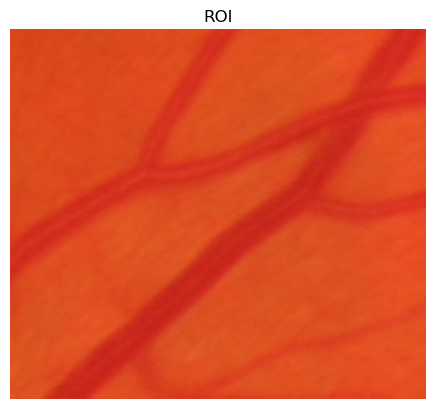

In [5]:
# initialize the list of reference points and boolean indicating
# whether cropping is being performed or not
refPt = []
cropping = False

def click_and_crop(event, x, y, flags, param):
    # grab references to the global variables
    global refPt, cropping
    
    # if the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
        cropping = True

    # check to see if the left mouse button was released
    elif event == cv2.EVENT_LBUTTONUP:
        # record the ending (x, y) coordinates and indicate that
        # the cropping operation is finished
        refPt.append((x, y))
        cropping = False
        
        # draw a rectangle around the region of interest
        cv2.rectangle(image, refPt[0], refPt[1], (0, 0, 0), 5)
        cv2.imshow('image', image)

# Load an image
image = cv2.imread(r"D:\Seminar\Datasets\healthy\06_h.jpg")

clone = image.copy()
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.setMouseCallback('image', click_and_crop)

while True:
    # display the image and wait for a keypress
    cv2.imshow('image', image)
    key = cv2.waitKey(1) & 0xFF

    # if the 'r' key is pressed, reset the cropping region
    if key == ord('r'):
        image = clone.copy()

    # if the 's' key is pressed, save the cropped region
    elif key == ord('s'):
        if len(refPt) == 2:
            roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
            cv2.imwrite('roi.jpg', roi)
            print("Cropped ROI saved as 'roi.jpg'.")

    # if the 'q' key is pressed, break from the loop
    elif key == ord('q'):
        break
        
# if there are two reference points, then crop the region of interest
# from the image and display it        
if len(refPt) == 2:
    roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
    cv2.imshow('ROI', roi)
    cv2.waitKey(0)

# Display the ROI 
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.title('ROI')
plt.axis('off')
plt.show()

# Close OpenCV windows
cv2.destroyAllWindows()

---
# 2. Image Filtering : 
The region of interest should be enhanced to remove imaging artifacts that affect the extraction of vessel edges. 

The `median filter` is a widely used nonlinear filter that we used to remove noise from the resulting image because it preserves edges and removes noise under certain conditions.

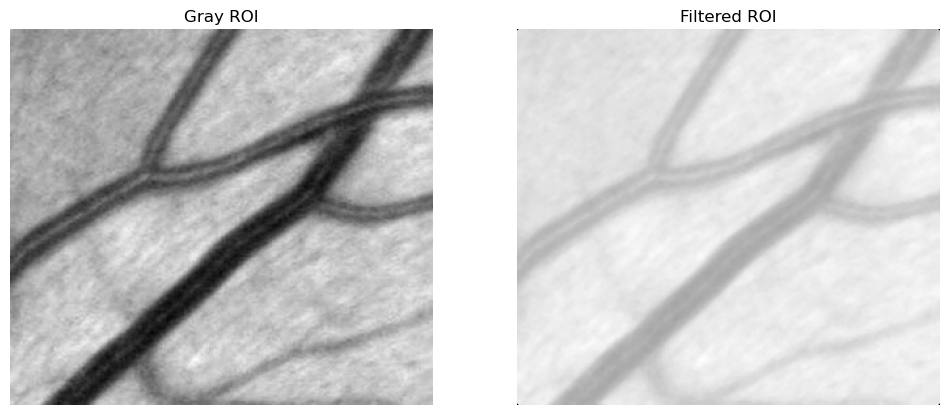

In [6]:
# Convert the Image to Grayscale
roi_gray = cv2.imread('roi.jpg',0)

def median_filter(image, ksize):

    # Create a new image of the same size as the input image
    filtered_img = np.zeros_like(image)
    # Apply Zero Padding
    padded_img = np.pad(image, ksize//2, mode='constant')

    # Loop over the image pixels
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):

          # Get the neighboring pixels
            neighbors = padded_img[i:i+ksize, j:j+ksize]
          # Find the median value
            median = np.median(neighbors)
          # Assign the median value to the filtered image
            filtered_img[i,j] = median

    return filtered_img

# Apply median filter to 'roi_gray'
roi_filtered = median_filter(roi_gray, 3)

# Display the Gray ROI and Filtered ROI
plt.figure(figsize=(12, 10))

plt.subplot(121)
plt.imshow(roi_gray, cmap='gray')
plt.title('Gray ROI')
plt.axis('off')

plt.subplot(122)
plt.imshow(roi_filtered, cmap='gray')
plt.title('Filtered ROI')
plt.axis('off')

plt.show()

---
# 3. Image Binarization :

The region of interest is then binarized using a threshold value that is automatically selected according to the histogram of the selected window .

(using Otsu's threshold)

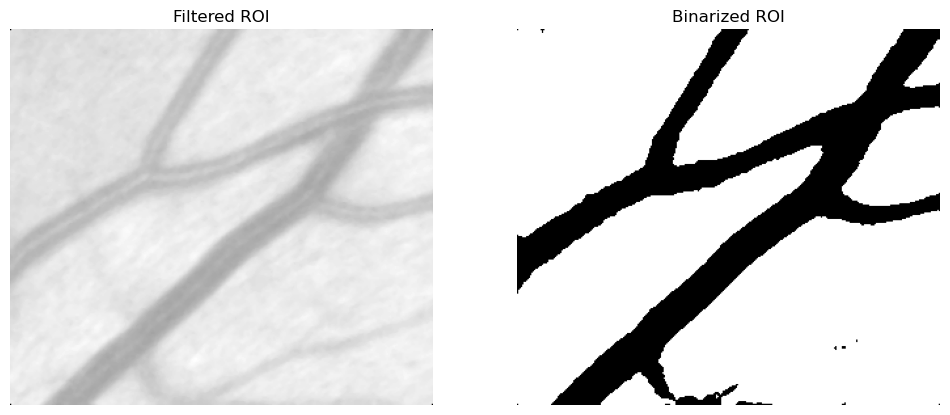

In [7]:
def binarize_image_with_otsu(image):
    
    # Calculate histogram
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])

    # Calculate cumulative distribution function (CDF)
    cdf = hist.cumsum()

    # Normalize CDF to [0, 1]
    cdf_normalized = cdf / cdf.max()

    # Otsu's method
    otsu_threshold, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Binarize the image using Otsu's threshold
    binary_image = np.zeros_like(image)
    binary_image[image > otsu_threshold] = 255

    return binary_image

# Apply the binarization function to the 'roi_filtered'
roi_binarized = binarize_image_with_otsu(roi_filtered)

# Display the Filtered ROI and Binarized ROI
plt.figure(figsize=(12, 10))

plt.subplot(121)
plt.imshow(roi_filtered, cmap='gray')
plt.title('Filtered ROI')
plt.axis('off')

plt.subplot(122)
plt.imshow(roi_binarized, cmap='gray')
plt.title('Binarized ROI')
plt.axis('off')

plt.show()

---
# 4. Edge Detection :

Morphological image processing is performed in the region of interest  to extract vessel edges.

First, we use `opening` for removing noise and small objects from the image while preserving the overall structure.

Then, using the `canny` method, we extracted the edges of the vessels.

And finally, we used the `thinning` operator to thin the edges.

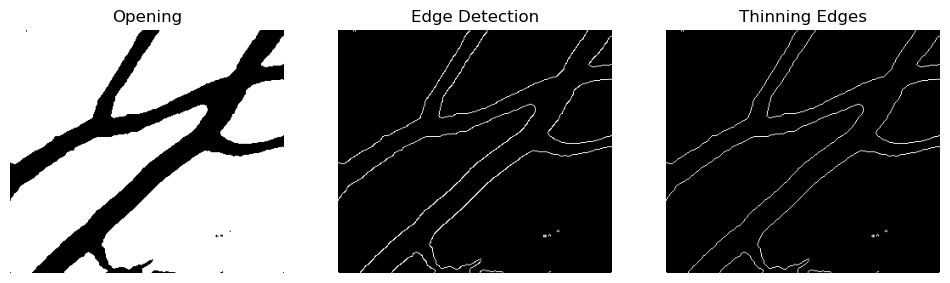

In [8]:
# Create an elliptical kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Apply morphological opening to the 'roi_binarized'
roi_open = cv2.morphologyEx(roi_binarized, cv2.MORPH_OPEN, kernel)

# Apply the canny Edge Detector to the 'roi_filtered'
roi_edged = cv2.Canny(roi_open, 100,200)

# Apply morphological thinning to the 'roi_edged'
roi_thinned_edge = thin(roi_edged)

# Display Results
plt.figure(figsize=(12, 10))

plt.subplot(131) 
plt.imshow(roi_open, cmap='gray')
plt.title('Opening')
plt.axis('off')

plt.subplot(132)  
plt.imshow(roi_edged, cmap='gray')
plt.title('Edge Detection')
plt.axis('off')

plt.subplot(133)  
plt.imshow(roi_thinned_edge, cmap='gray')
plt.title('Thinning Edges')
plt.axis('off')

plt.show()

---
# 5. Skeletonization :

We used `skeletonization` to minimize foreground regions in a binary image that preserves the extent and connectivity of the original region and removes most of the original foreground pixels.

And finally, we used the `thinning` operator to thin the skeleton.

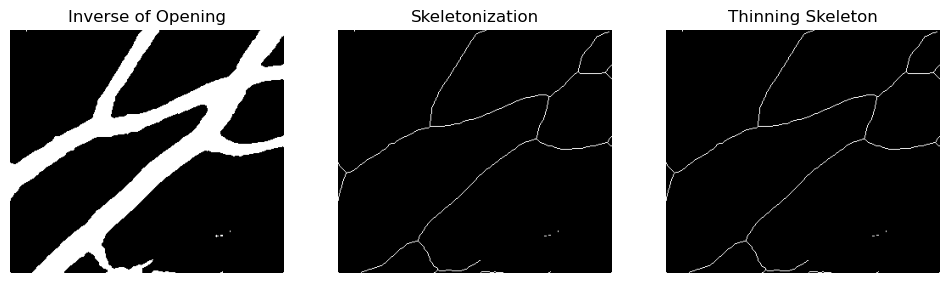

In [9]:
# Inverted the binary image
roi_binarized_invert = invert(roi_binarized)

# Inverted the Opening
roi_open_invert = invert(roi_open)

# Apply morphological skeletonize to the 'roi_open_invert'
roi_skeleton = skeletonize(roi_open_invert)

# Apply morphological thinning to the 'roi_skeleton'
roi_thinned_skelton = thin(roi_skeleton)

# Display Results
plt.figure(figsize=(12, 10))

plt.subplot(131) 
plt.imshow(roi_open_invert, cmap='gray')
plt.title('Inverse of Opening')
plt.axis('off')

plt.subplot(132)  
plt.imshow(roi_skeleton, cmap='gray')
plt.title('Skeletonization')
plt.axis('off')

plt.subplot(133)  
plt.imshow(roi_thinned_skelton, cmap='gray')
plt.title('Thinning Skeleton')
plt.axis('off')

plt.show()

---
# Results:

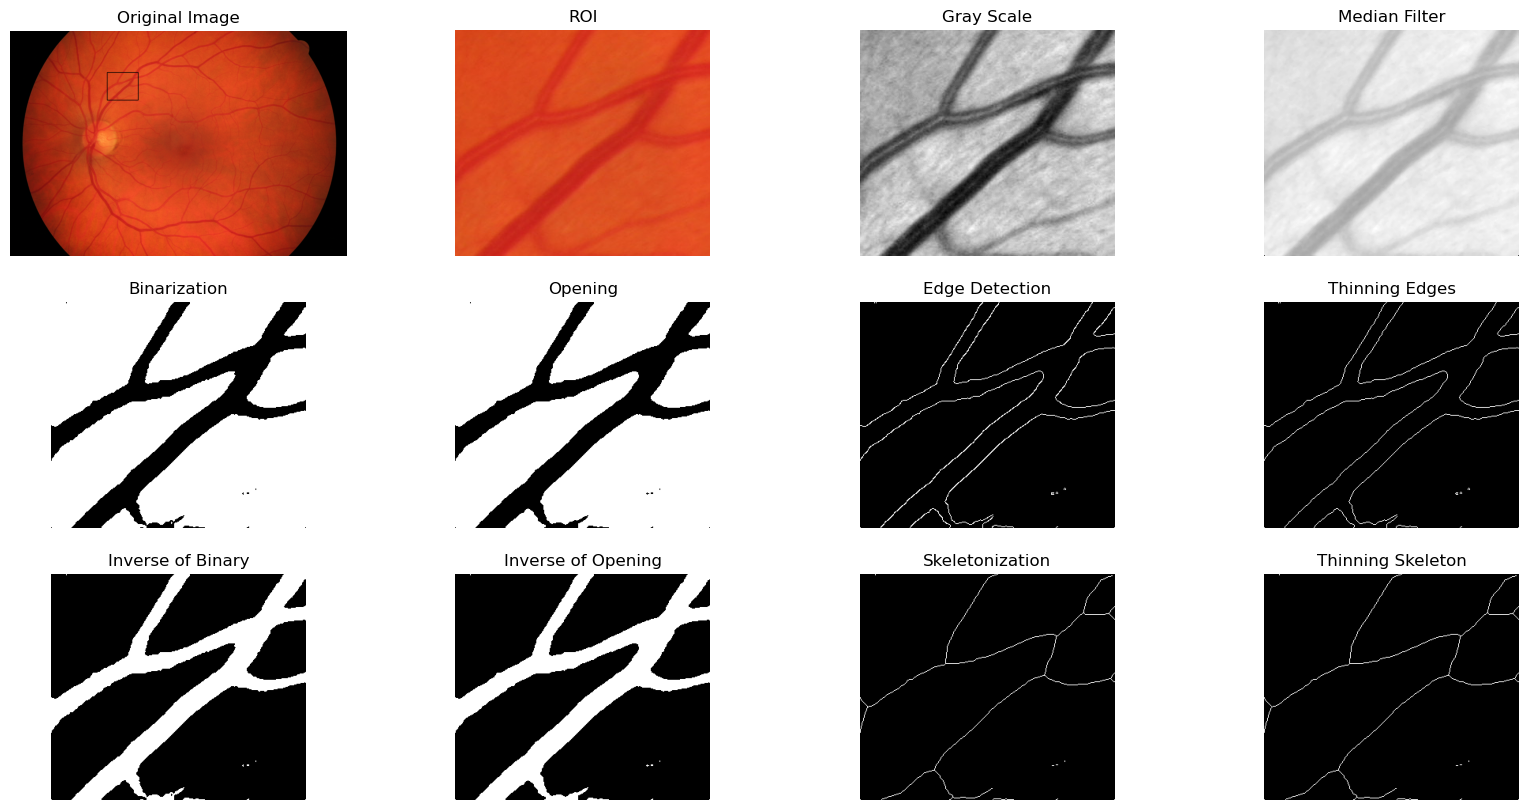

In [10]:
# Display Results
plt.figure(figsize=(20, 10))

plt.subplot(341)  
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(342)  
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.title('ROI')
plt.axis('off')

plt.subplot(343) 
plt.imshow(roi_gray, cmap='gray')
plt.title('Gray Scale')
plt.axis('off')

plt.subplot(344)  
plt.imshow(roi_filtered, cmap='gray')
plt.title('Median Filter')
plt.axis('off')

plt.subplot(345)  
plt.imshow(roi_binarized, cmap='gray')
plt.title('Binarization')
plt.axis('off')

plt.subplot(346) 
plt.imshow(roi_open, cmap='gray')
plt.title('Opening')
plt.axis('off')

plt.subplot(347)  
plt.imshow(roi_edged, cmap='gray')
plt.title('Edge Detection')
plt.axis('off')

plt.subplot(348)  
plt.imshow(roi_thinned_edge, cmap='gray')
plt.title('Thinning Edges')
plt.axis('off')

plt.subplot(349) 
plt.imshow(roi_binarized_invert, cmap='gray')
plt.title('Inverse of Binary')
plt.axis('off')

plt.subplot(3, 4, 10) 
plt.imshow(roi_open_invert, cmap='gray')
plt.title('Inverse of Opening')
plt.axis('off')

plt.subplot(3, 4, 11)   
plt.imshow(roi_skeleton, cmap='gray')
plt.title('Skeletonization')
plt.axis('off')

plt.subplot(3, 4, 12)  
plt.imshow(roi_thinned_skelton, cmap='gray')
plt.title('Thinning Skeleton')
plt.axis('off')

plt.show()

---
---
# Vessel Segmentation :
This code performs segmentation of blood vessels using scikit image library in Python. Here is an explanation of each part of the code:

* **Multi-Otsu Thresholding :**


Multi-Otsu thresholding is applied to the grayscale image (image_gray) to obtain multiple threshold values (t0 and t1). The classes parameter is set to 3, indicating the desired number of classes for segmentation.

* **Create Binary Mask:**

A binary mask is created based on the threshold (t0). Pixels with intensity values greater than t0 are set to True, and those less than or equal to t0 are set to False. This mask is used to focus on the regions of interest in the subsequent step.

* **Vessel Enhancement using Sato Filter:**

The Sato filter is applied to enhance blood vessels in the grayscale image (image_gray). The sigmas parameter specifies a range of scales for which the filter is applied. The result is multiplied by the binary mask created in the previous step to focus on the segmented vessels.

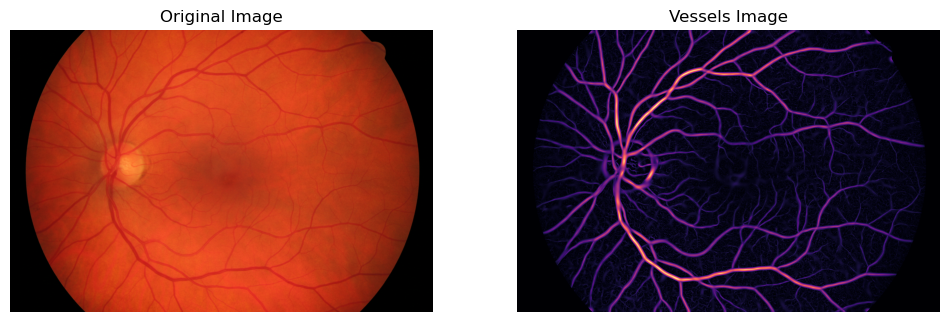

In [11]:
# Read the original color image
org_image = cv2.imread(r"D:\Seminar\Datasets\healthy\06_h.jpg")

# Convert the original color image to grayscale
image_gray = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)

# Perform Multi-Otsu thresholding to obtain multiple thresholds
t0, t1 = filters.threshold_multiotsu(image_gray, classes=3)

# Create a binary mask based on the first threshold (t0)
mask = (image_gray > t0)

# Apply the Sato filter to enhance blood vessels with different scales
# The result is multiplied by the binary mask to focus on vessel regions
vessels = filters.sato(image_gray, sigmas=range(1, 20)) * mask

# Display the results
plt.figure(figsize=(12, 10))

plt.subplot(121)
plt.imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(vessels, cmap='magma')
plt.title('Vessels Image')
plt.axis('off')

plt.show()

---
---

#  Segmentation Evaluation :

This Python code defines an evaluation function, `evaluation_code`, for assessing the performance of a vessel segmentation model that discriminates arteries and veins. The function takes the predicted vessel segmentation image and the corresponding ground truth image as inputs. It encodes these images to represent arteries, veins, and background pixels, then computes various evaluation metrics. These metrics include accuracy and F1 score for the full image, discovered centerline pixels, discovered centerline pixels limited to vessels wider than two pixels, and all centerline pixels in the ground truth. Additionally, the code calculates the vessel detection rate. The provided example loads predicted and ground truth images, displays them side by side, and then evaluates the model using the `evaluation_code` function, printing the computed metrics. This code facilitates a comprehensive assessment of vessel segmentation performance, considering different aspects of the segmentation results.



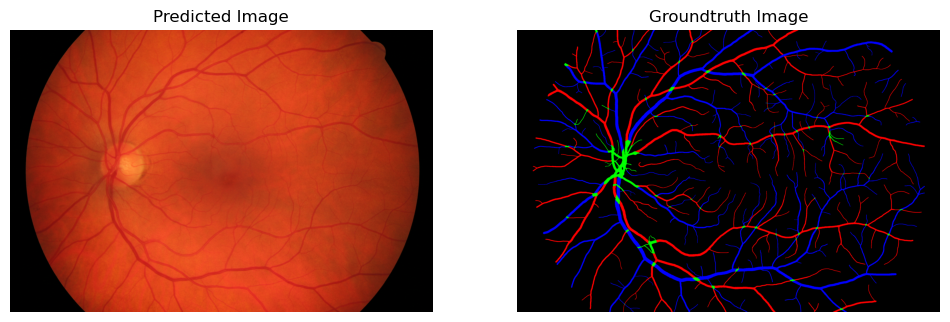

Full image
Accuracy: 0.9059212416729218
F1: 0.8614865007442608

Discovered centerline pixels
Accuracy: 1.0
F1: 1.0

Discovered centerline pixels of vessels wider than two pixels
Accuracy: 1.0
F1: 1.0

Centerline pixels
Accuracy: 6.794863083508867e-05
F1: 0.0001358786251833877

Amount of vessels detected: 4.038056730789271e-05
Metrics 1: [0.9059212416729218, 0.8614865007442608]
Metrics 2: [1.0, 1.0]
Metrics 3: [1.0, 1.0]
Metrics 4: [6.794863083508867e-05, 0.0001358786251833877]
Detection Rate: 4.038056730789271e-05


In [15]:
def evaluation_code(prediction, groundtruth):
    '''
    Function to evaluate the performance of AV predictions with a given ground truth
    - prediction: should be an image array of [dim1, dim2, img_channels = 3] with arteries in red and veins in blue
    - groundtruth: same as above
    '''
    
    encoded_pred = np.zeros(prediction.shape[:2], dtype=int)
    encoded_gt = np.zeros(groundtruth.shape[:2], dtype=int)
    
    # convert white pixels to green pixels (which are ignored)
    white_ind = np.where(np.logical_and(groundtruth[:,:,0] == 255, groundtruth[:,:,1] == 255, groundtruth[:,:,2] == 255))
    if white_ind[0].size != 0:
        groundtruth[white_ind] = [0,255,0]
        
    # translate the images to arrays suited for sklearn metrics
    arteriole = np.where(np.logical_and(groundtruth[:,:,0] == 255, groundtruth[:,:,1] == 0)); encoded_gt[arteriole] = 1
    venule = np.where(np.logical_and(groundtruth[:,:,2] == 255, groundtruth[:,:,1] == 0)); encoded_gt[venule] = 2
    arteriole = np.where(prediction[:,:,0] == 255); encoded_pred[arteriole] = 1
    venule = np.where(prediction[:,:,2] == 255); encoded_pred[venule] = 2
   
    # retrieve the indices for the centerline pixels present in the prediction
    center = np.where(np.logical_and(
        np.logical_or((skeletonize(groundtruth[:,:,0] > 0)),(skeletonize(groundtruth[:,:,2] > 0))),
        encoded_pred[:,:] > 0))
    
    encoded_pred_center = encoded_pred[center]
    encoded_gt_center = encoded_gt[center]
    
    # retrieve the indices for the centerline pixels present in the groundtruth
    center_comp = np.where(
        np.logical_or(skeletonize(groundtruth[:,:,0] > 0),skeletonize(groundtruth[:,:,2] > 0)))
    
    encoded_pred_center_comp = encoded_pred[center_comp]
    encoded_gt_center_comp = encoded_gt[center_comp]
    
    # retrieve the indices for discovered centerline pixels - limited to vessels wider than two pixels (for DRIVE)
    center_eroded = np.where(np.logical_and(
        np.logical_or(skeletonize(erosion(groundtruth[:,:,0] > 0)),skeletonize(erosion(groundtruth[:,:,2] > 0))),
        encoded_pred[:,:] > 0))
                             
    encoded_pred_center_eroded = encoded_pred[center_eroded]
    encoded_gt_center_eroded = encoded_gt[center_eroded]
    
    # metrics over full image
    cur1_acc = accuracy_score(encoded_gt.flatten(),encoded_pred.flatten())
    cur1_F1 = f1_score(encoded_gt.flatten(),encoded_pred.flatten(),average='weighted')
    print('Full image')
    print('Accuracy: {}\nF1: {}\n'.format(cur1_acc, cur1_F1))
    metrics1 = [cur1_acc, cur1_F1]
    
    # metrics over discovered centerline pixels
    cur2_acc = accuracy_score(encoded_gt_center.flatten(),encoded_pred_center.flatten())
    cur2_F1 = f1_score(encoded_gt_center.flatten(),encoded_pred_center.flatten(),average='weighted')
    print('Discovered centerline pixels')
    print('Accuracy: {}\nF1: {}\n'.format(cur2_acc, cur2_F1))
    metrics2 = [cur2_acc, cur2_F1]
    
    # metrics over discovered centerline pixels - limited to vessels wider than two pixels
    cur3_acc = accuracy_score(encoded_gt_center_eroded.flatten(),encoded_pred_center_eroded.flatten())
    cur3_F1 = f1_score(encoded_gt_center_eroded.flatten(),encoded_pred_center_eroded.flatten(),average='weighted')
    print('Discovered centerline pixels of vessels wider than two pixels')
    print('Accuracy: {}\nF1: {}\n'.format(cur3_acc, cur3_F1))
    metrics3 = [cur3_acc, cur3_F1]
    
    # metrics over all centerline pixels in ground truth
    cur4_acc = accuracy_score(encoded_gt_center_comp.flatten(),encoded_pred_center_comp.flatten())
    cur4_F1 = f1_score(encoded_gt_center_comp.flatten(),encoded_pred_center_comp.flatten(),average='weighted')
    print('Centerline pixels')
    print('Accuracy: {}\nF1: {}\n'.format(cur4_acc, cur4_F1))
    metrics4 = [cur4_acc, cur4_F1]
    
    # finally, compute vessel detection rate
    vessel_ind = np.where(encoded_gt>0)
    vessel_gt = encoded_gt[vessel_ind]
    vessel_pred = encoded_pred[vessel_ind]
    
    detection_rate = accuracy_score(vessel_gt.flatten(),vessel_pred.flatten())
    print('Amount of vessels detected: ' + str(detection_rate))
    
    return [metrics1,metrics2,metrics3,metrics4,detection_rate]
    
# Load your predicted and ground truth images
predicted_image = cv2.imread(r"D:\Seminar\Datasets\healthy\06_h.jpg")
groundtruth_image = cv2.imread(r"D:\Seminar\Datasets\HRF_AV_GT\06_h_AVmanual.png")

plt.figure(figsize=(12, 10))

plt.subplot(121)
plt.imshow(cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB))
plt.title('Predicted Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(groundtruth_image, cv2.COLOR_BGR2RGB))
plt.title('Groundtruth Image')
plt.axis('off')

plt.show()

# Call the evaluation_code function
results = evaluation_code(predicted_image, groundtruth_image)

# Print or use the results as needed
print("Metrics 1:", results[0])
print("Metrics 2:", results[1])
print("Metrics 3:", results[2])
print("Metrics 4:", results[3])
print("Detection Rate:", results[4])

---
---